In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer
import ELPH_Dim_Reducer
import ELPH_VAR_Transformer

from ELPH_RDNLVAR import RDNLVAR

In [2]:
# runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')
# runs = ELPH_utils.load_runs(filename='../runs.npz')
runs = ELPH_utils.load_runs(filename='../runs_nkmax_80.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


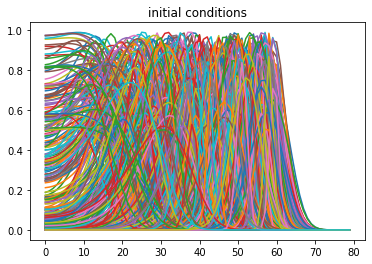

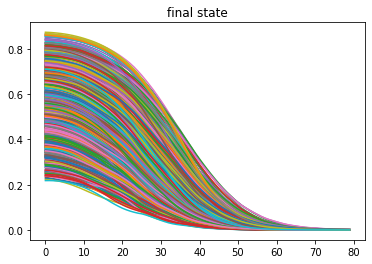

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (861, 399000)
target shape:  (30, 399000)
weights shape:  (861, 30)


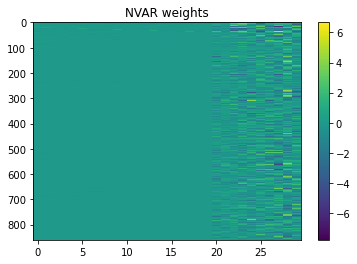

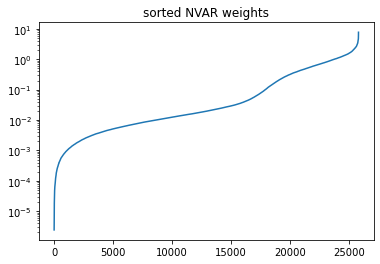

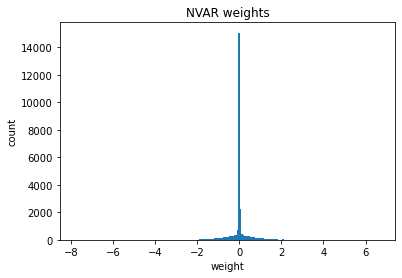

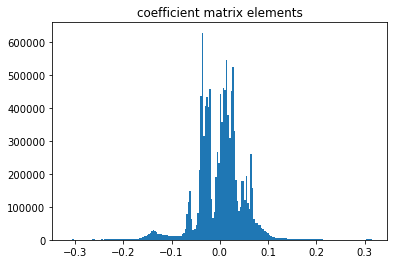

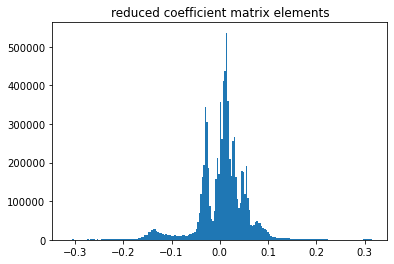

In [4]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(0.63)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

model = RDNLVAR(runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)
model.print_status()

plt.imshow(model.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

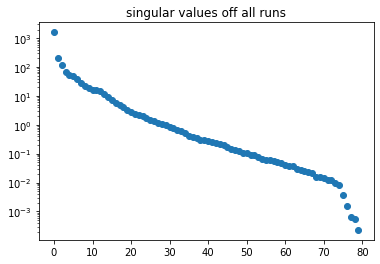

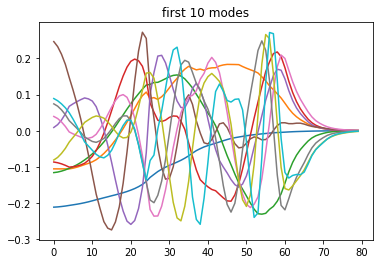

In [5]:
plt.semilogy(dim_reducer.S, 'o')
plt.title('singular values off all runs')
plt.show()

rdim = 10
for l in range(rdim):
  plt.plot(dim_reducer.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()

In [7]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.0)
scaler = ELPH_Scaler.normalize_scaler(0.63)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
score_kwargs = {'norm':'max'}


m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.024890735664728932
0.00190213660725318
[0.028440147557634167, 0.02457237464628253, 0.023899186290784503, 0.024745686456823845, 0.02279628337211963]


rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (861, 398601)
target shape:  (30, 398601)
weights shape:  (861, 30)
error:  0.008127781451592986


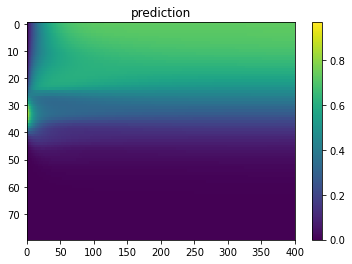

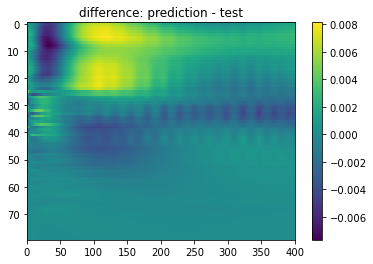

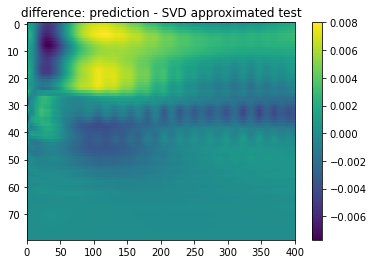

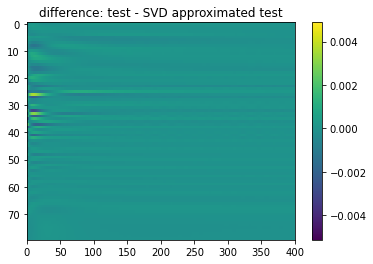

In [18]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.0)
scaler = ELPH_Scaler.normalize_scaler(0.63)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_runs = runs[::1]
test_run = train_runs.pop(17)

model.load_runs(train_runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)

model.print_status()


print('error: ', model.get_error(test_run, norm='max') )

pred = model.predict_single_run(test_run)

xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


test_run_SVDapprx = dim_reducer.U[:,:30] @ dim_reducer.U[:,:30].T @ test_run

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


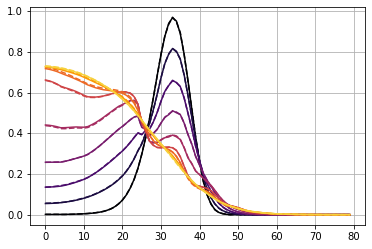

std error:  0.0023778631241975485
max abs error:  0.008127781451592986


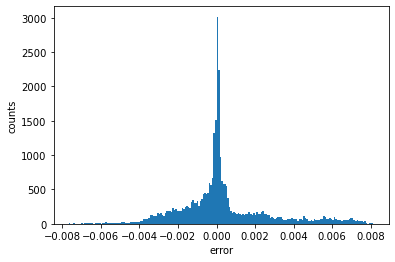

In [19]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [ ]:
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)

    
    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
    score_kwargs = {'norm':'max'}
    
    m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,1.0]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |   aExp    | rel_scale |
-------------------------------------------------
|  1        | -0.02597  | -3.007    |  0.3326   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  2        | -10.0     | -4.485    |  0.3198   |
|  3        | -10.0     | -2.094    |  0.6728   |
|  4        | -10.0     | -2.661    |  0.4647   |
|  5        | -0.02733  | -3.044    |  0.1073   |
|  6        | -10.0     | -3.43     |  0.8916   |
